# Всероссийская студенческая Актионада – Кейс-чемпионат «РЕСТАРТ» 2025 по направлению «IT» 2 этап

## Задание 1. Классификация бухгалтерских проводок — на основе USA Banking Transactions Dataset

**Описание задачи:**
У компании есть выгрузка транзакций (аналог бухгалтерских проводок): дата, сумма, тип операции (дебет/кредит или Debit/Credit), контрагент (merchant), категория расходов (например, еда, транспорт, подписки и т.п.), возможно описание операции и способ оплаты.

Каждая транзакция должна быть отнесена к одному из классов транзакции — например: «здоровье», «одежда», «налоги», «аренда», «командировочные расходы» и т.д.

**Данные:**
- Дата транзакции
- Сумма (Transaction_Amount)
- Тип транзакции (Debit / Credit)
- Контрагент / Торговец
- Категория / подкатегория (если версия датасета содержит метки)

**Метрика оценки качества:**
- Macro F1-score (среднее макро по всем категориям).


**Задания:**
 
1) На основе предоставленного датасета провести анализ, который должен включать:
- Распределение целевой переменной Category (число классов, уровень дисбаланса).
- Анализ пропущенных значений во всех признаках.
- Статистический анализ признака Transaction_Amount (распределение, выбросы, различия для дебетовых/кредитовых операций).
- Анализ признака Merchant (топ-10 самых частых контрагентов).

2) Разработать и реализовать код пайплайна, который выполняет:
- Обработку пропущенных значений в текстовых полях (например, Merchant) заполнением строкой 'UNKNOWN'.
- Извлечение из Date как минимум трех новых признаков (например, день недели, месяц, является ли день выходным).
- Векторизацию текстового поля Merchant с помощью метода CountVectorizer с параметрами по умолчанию.
- Объединение всех признаков (числовых, категориальных, временных, текстовых) в единую матрицу для обучения.


### Загрузка и обработка данных 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [2]:
try:
    df = pd.read_csv('Daily Household Transactions.csv')
except:
    df = pd.read_csv('C:/Users/Михаил/Daily Household Transactions.csv')
df.head()

,Date,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency
0,20/09/2018 12:04:08,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
1,20/09/2018 12:03:15,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2,19/09/2018,Saving Bank account 1,subscription,Netflix,1 month subscription,199.0,Expense,INR
3,17/09/2018 23:41:17,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR
4,16/09/2018 17:15:08,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2461 non-null   object 
 1   Mode            2461 non-null   object 
 2   Category        2461 non-null   object 
 3   Subcategory     1826 non-null   object 
 4   Note            1940 non-null   object 
 5   Amount          2461 non-null   float64
 6   Income/Expense  2461 non-null   object 
 7   Currency        2461 non-null   object 
dtypes: float64(1), object(7)
memory usage: 153.9+ KB


In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,2461,1611,1/1/2015,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mode,2461,12,Saving Bank account 1,1223,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,2461,50,Food,907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subcategory,1826,90,Milk,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Note,1940,1057,milk 1lit,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,2461.0,NaN,NaN,NaN,2751.14538,12519.615804,2.0,35.0,100.0,799.0,250000.0
Income/Expense,2461,3,Expense,2176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Currency,2461,1,INR,2461,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print('Дубликатов:', df.duplicated().sum())

Дубликатов: 9


In [6]:
df = df.drop_duplicates()

In [7]:
df.isna().sum()

Date                0
Mode                0
Category            0
Subcategory       629
Note              512
Amount              0
Income/Expense      0
Currency            0
dtype: int64

### Анализ

In [8]:
n_classes = df['Category'].nunique()
print(f"Число уникальных классов: {n_classes}")

# Распределение по категориям
category_counts = df['Category'].value_counts()
category_percentages = df['Category'].value_counts(normalize=True) * 100

print(f"\nРаспределение по категориям:")
for category, count, percentage in zip(category_counts.index, category_counts.values, category_percentages.values):
    print(f"{category}: {count} наблюдений ({percentage:.2f}%)")

print(f"\n   Всего наблюдений: {len(df)}")

Число уникальных классов: 50

Распределение по категориям:
Food: 906 наблюдений (36.95%)
Transportation: 307 наблюдений (12.52%)
Household: 176 наблюдений (7.18%)
subscription: 143 наблюдений (5.83%)
Other: 126 наблюдений (5.14%)
Investment: 101 наблюдений (4.12%)
Health: 94 наблюдений (3.83%)
Family: 71 наблюдений (2.90%)
Apparel: 47 наблюдений (1.92%)
Money transfer: 43 наблюдений (1.75%)
Salary: 43 наблюдений (1.75%)
Recurring Deposit: 41 наблюдений (1.67%)
Gift: 30 наблюдений (1.22%)
Public Provident Fund: 29 наблюдений (1.18%)
Equity Mutual Fund E: 22 наблюдений (0.90%)
Beauty: 22 наблюдений (0.90%)
Gpay Reward: 21 наблюдений (0.86%)
Education: 18 наблюдений (0.73%)
maid: 17 наблюдений (0.69%)
Saving Bank account 1: 17 наблюдений (0.69%)
Festivals: 16 наблюдений (0.65%)
Equity Mutual Fund A: 14 наблюдений (0.57%)
Equity Mutual Fund F: 13 наблюдений (0.53%)
Interest: 12 наблюдений (0.49%)
Dividend earned on Shares: 12 наблюдений (0.49%)
Culture: 11 наблюдений (0.45%)
Small cap fund

In [9]:
# Анализ дисбаланса
majority_class = category_counts.idxmax()
minority_class = category_counts.idxmin()
majority_count = category_counts.max()
minority_count = category_counts.min()
imbalance_ratio = majority_count / minority_count

print(f"Самый частый класс: '{majority_class}' ({majority_count} наблюдений)")
print(f"Самый редкий класс: '{minority_class}' ({minority_count} наблюдений)")
print(f"Коэффициент дисбаланса: {imbalance_ratio:.2f}")

Самый частый класс: 'Food' (906 наблюдений)
Самый редкий класс: 'Equity Mutual Fund B' (1 наблюдений)
Коэффициент дисбаланса: 906.00


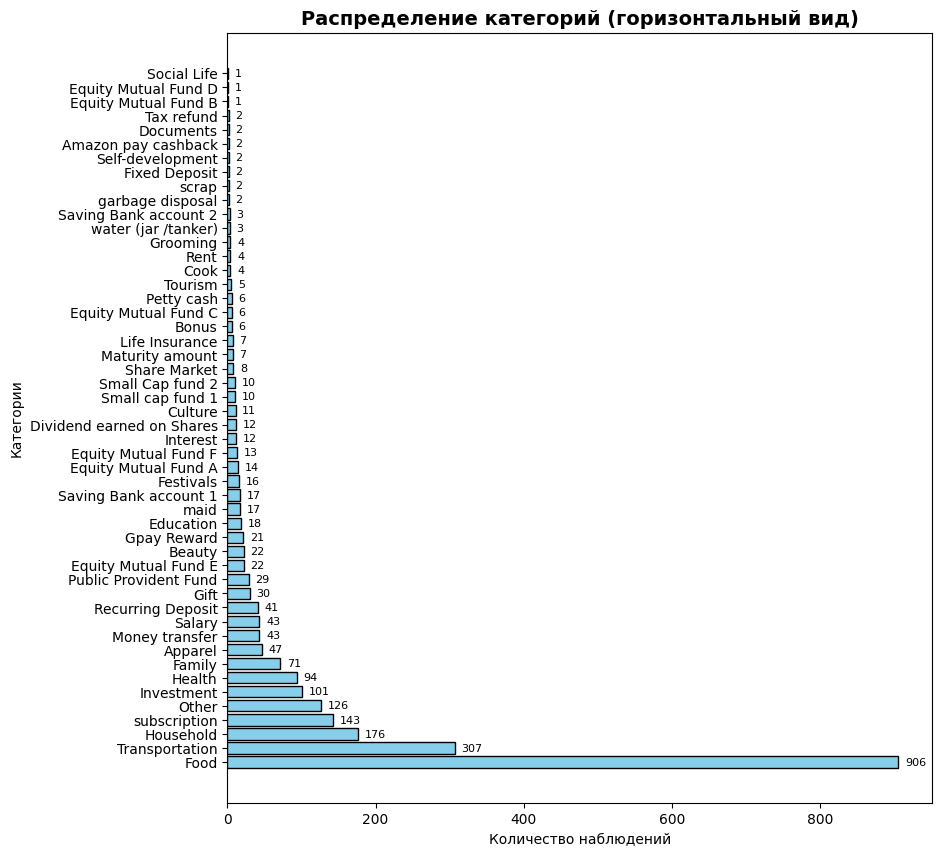

In [10]:
# Визуализация распределения
plt.figure(figsize=(20, 10))

# Горизонтальная столбчатая диаграмма
plt.subplot(1, 2, 1)
bars = plt.barh(range(len(category_counts)), category_counts.values, color='skyblue', edgecolor='black')
plt.title('Распределение категорий (горизонтальный вид)', fontsize=14, fontweight='bold')
plt.ylabel('Категории')
plt.xlabel('Количество наблюдений')
plt.yticks(range(len(category_counts)), category_counts.index)

# Добавляем подписи значений
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(category_counts.values) * 0.01, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontsize=8)

In [11]:
# Сводная таблица
print(f"\n4. Сводная таблица распределения:")

summary_df = pd.DataFrame({
    'Категория': category_counts.index,
    'Абсолютная частота': category_counts.values,
    'Относительная частота %': category_percentages.values.round(2),
    'Отклонение от среднего': (category_counts.values - category_counts.mean()).round(1)
})

display(summary_df)


4. Сводная таблица распределения:


,Категория,Абсолютная частота,Относительная частота %,Отклонение от среднего
0,Food,906,36.95,857.0
1,Transportation,307,12.52,258.0
2,Household,176,7.18,127.0
3,subscription,143,5.83,94.0
4,Other,126,5.14,77.0
5,Investment,101,4.12,52.0
6,Health,94,3.83,45.0
7,Family,71,2.90,22.0
8,Apparel,47,1.92,-2.0
9,Money transfer,43,1.75,-6.0


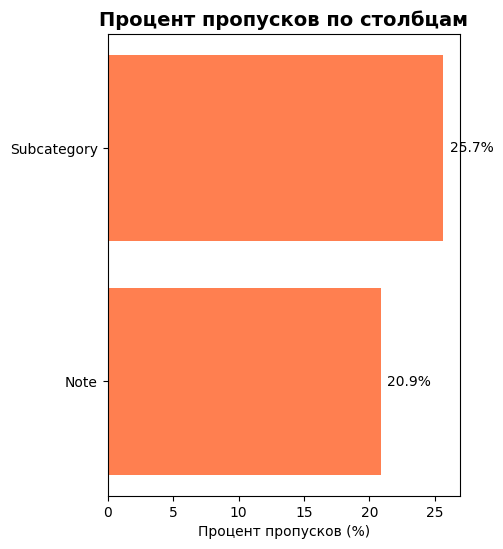

In [12]:
missing_data = df.isna().sum()
missing_percent = (df.isna().sum() / len(df)) * 100

# Визуализация пропущенных значений
plt.figure(figsize=(10, 6))

# Столбчатая диаграмма процента пропусков
plt.subplot(1, 2, 2)
missing_percent_sorted = missing_percent[missing_percent > 0].sort_values(ascending=True)
bars = plt.barh(missing_percent_sorted.index, missing_percent_sorted.values, color='coral')
plt.title('Процент пропусков по столбцам', fontsize=14, fontweight='bold')
plt.xlabel('Процент пропусков (%)')
    
# Добавляем подписи
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2., 
            f'{width:.1f}%', ha='left', va='center')

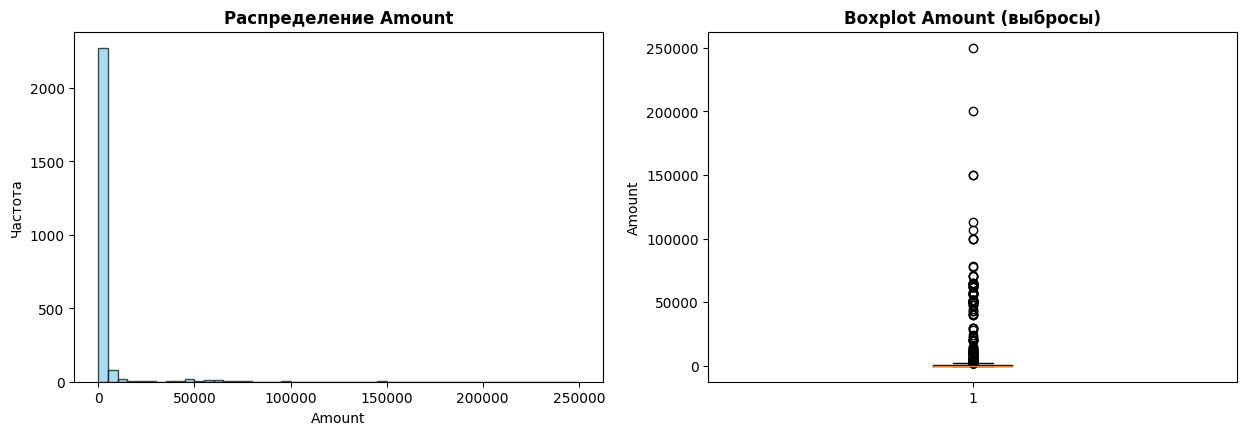

In [13]:
# Визуализация распределения Amount
plt.figure(figsize=(15, 10))

# Гистограмма и boxplot
plt.subplot(2, 2, 1)
plt.hist(df['Amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение Amount', fontsize=12, fontweight='bold')
plt.xlabel('Amount')
plt.ylabel('Частота')

plt.subplot(2, 2, 2)
plt.boxplot(df['Amount'])
plt.title('Boxplot Amount (выбросы)', fontsize=12, fontweight='bold')
plt.ylabel('Amount')
plt.show()

In [14]:
# Анализ выбросов
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)]
print(f"\nАнализ выбросов:")
print(f"Q1 (25% перцентиль): {Q1:.2f}")
print(f"Q3 (75% перцентиль): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Количество выбросов: {len(outliers)}")
print(f"Процент выбросов: {(len(outliers) / len(df) * 100):.2f}%")


Анализ выбросов:
Q1 (25% перцентиль): 35.00
Q3 (75% перцентиль): 784.50
IQR: 749.50
Границы выбросов: [-1089.25, 1908.75]
Количество выбросов: 315
Процент выбросов: 12.85%


In [15]:
# Анализ по типам операций
operation_stats = df.groupby('Income/Expense')['Amount'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

print("Статистика Amount по типам операций:")
display(operation_stats)

Статистика Amount по типам операций:


,count,mean,median,std,min,max
Income/Expense,,,,,,
Expense,2173,899.85,83.0,3840.59,2.00,100000.0
Income,125,24339.18,2000.0,30031.32,2.00,113376.0
Transfer-Out,154,11459.62,1500.0,32769.54,42.88,250000.0


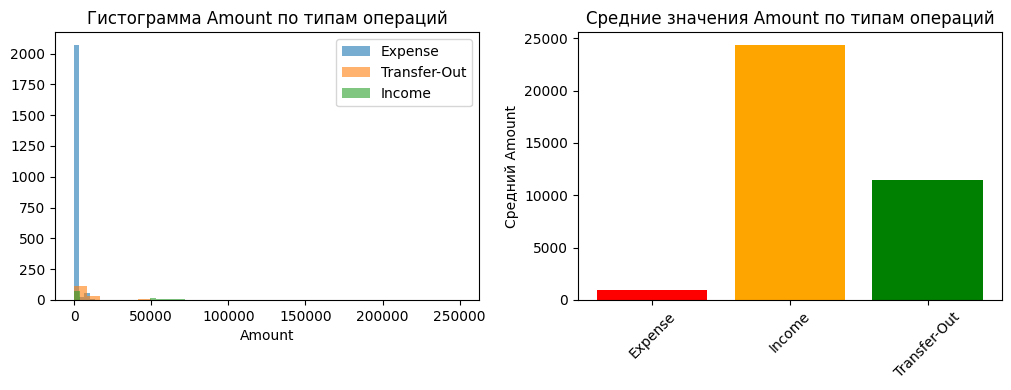


КЛЮЧЕВЫЕ ВЫВОДЫ:
Доходы (Income): 125 операций
Расходы (Expense): 2173 операций
Переводы (Transfer-Out): 154 операций


In [16]:
# Визуализация
plt.figure(figsize=(15, 4))

# Гистограмма
plt.subplot(1, 3, 2)
for operation in df['Income/Expense'].unique():
    plt.hist(df[df['Income/Expense'] == operation]['Amount'], 
             alpha=0.6, label=operation, bins=30)
plt.title('Гистограмма Amount по типам операций')
plt.xlabel('Amount')
plt.legend()

# Средние значения
plt.subplot(1, 3, 3)
means = df.groupby('Income/Expense')['Amount'].mean()
plt.bar(means.index, means.values, color=['red', 'orange', 'green'])
plt.title('Средние значения Amount по типам операций')
plt.xticks(rotation=45)
plt.ylabel('Средний Amount')

plt.tight_layout()
plt.show()

# Ключевые выводы
print("\nКЛЮЧЕВЫЕ ВЫВОДЫ:")
print(f"Доходы (Income): {len(df[df['Income/Expense'] == 'Income'])} операций")
print(f"Расходы (Expense): {len(df[df['Income/Expense'] == 'Expense'])} операций") 
print(f"Переводы (Transfer-Out): {len(df[df['Income/Expense'] == 'Transfer-Out'])} операций")